In [188]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [190]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
train_path = '/content/drive/MyDrive/Dataset/train'
test_path = '/content/drive/MyDrive/Dataset/test'

In [192]:
folders = glob('/content/drive/MyDrive/Dataset/train/*')
print(len(folders))

2


In [193]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [194]:
test_datagen = ImageDataGenerator(
    rescale=1./255)

In [195]:
train_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size=32,
                                
                                                 class_mode = 'categorical')

Found 4686 images belonging to 2 classes.


In [196]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            batch_size=32,
                                            class_mode = 'categorical')

Found 1170 images belonging to 2 classes.


In [197]:
input_tensor=Input(shape=(224,224,3))

In [198]:
base_model1 = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
features1 = base_model1.output
for layer in base_model1.layers:
  layer.trainable=True
for layer in base_model1.layers:  
  layer._name = layer._name + str('_C')

In [199]:
base_model2 = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
features2 = base_model2.output
for layer in base_model2.layers:
  layer.trainable=True
for layer in base_model2.layers:  
  layer._name = layer._name + str('_D')

In [200]:
from tensorflow.keras.layers import concatenate
concatenated=concatenate([features1,features2]) 

In [201]:
x = Flatten(name='flatten')(concatenated)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dropout(0.5)(x)
x = Dense(len(folders), activation='softmax', name='predictions')(x)

In [202]:
Concatenated_model = Model(inputs=input_tensor, outputs=x)

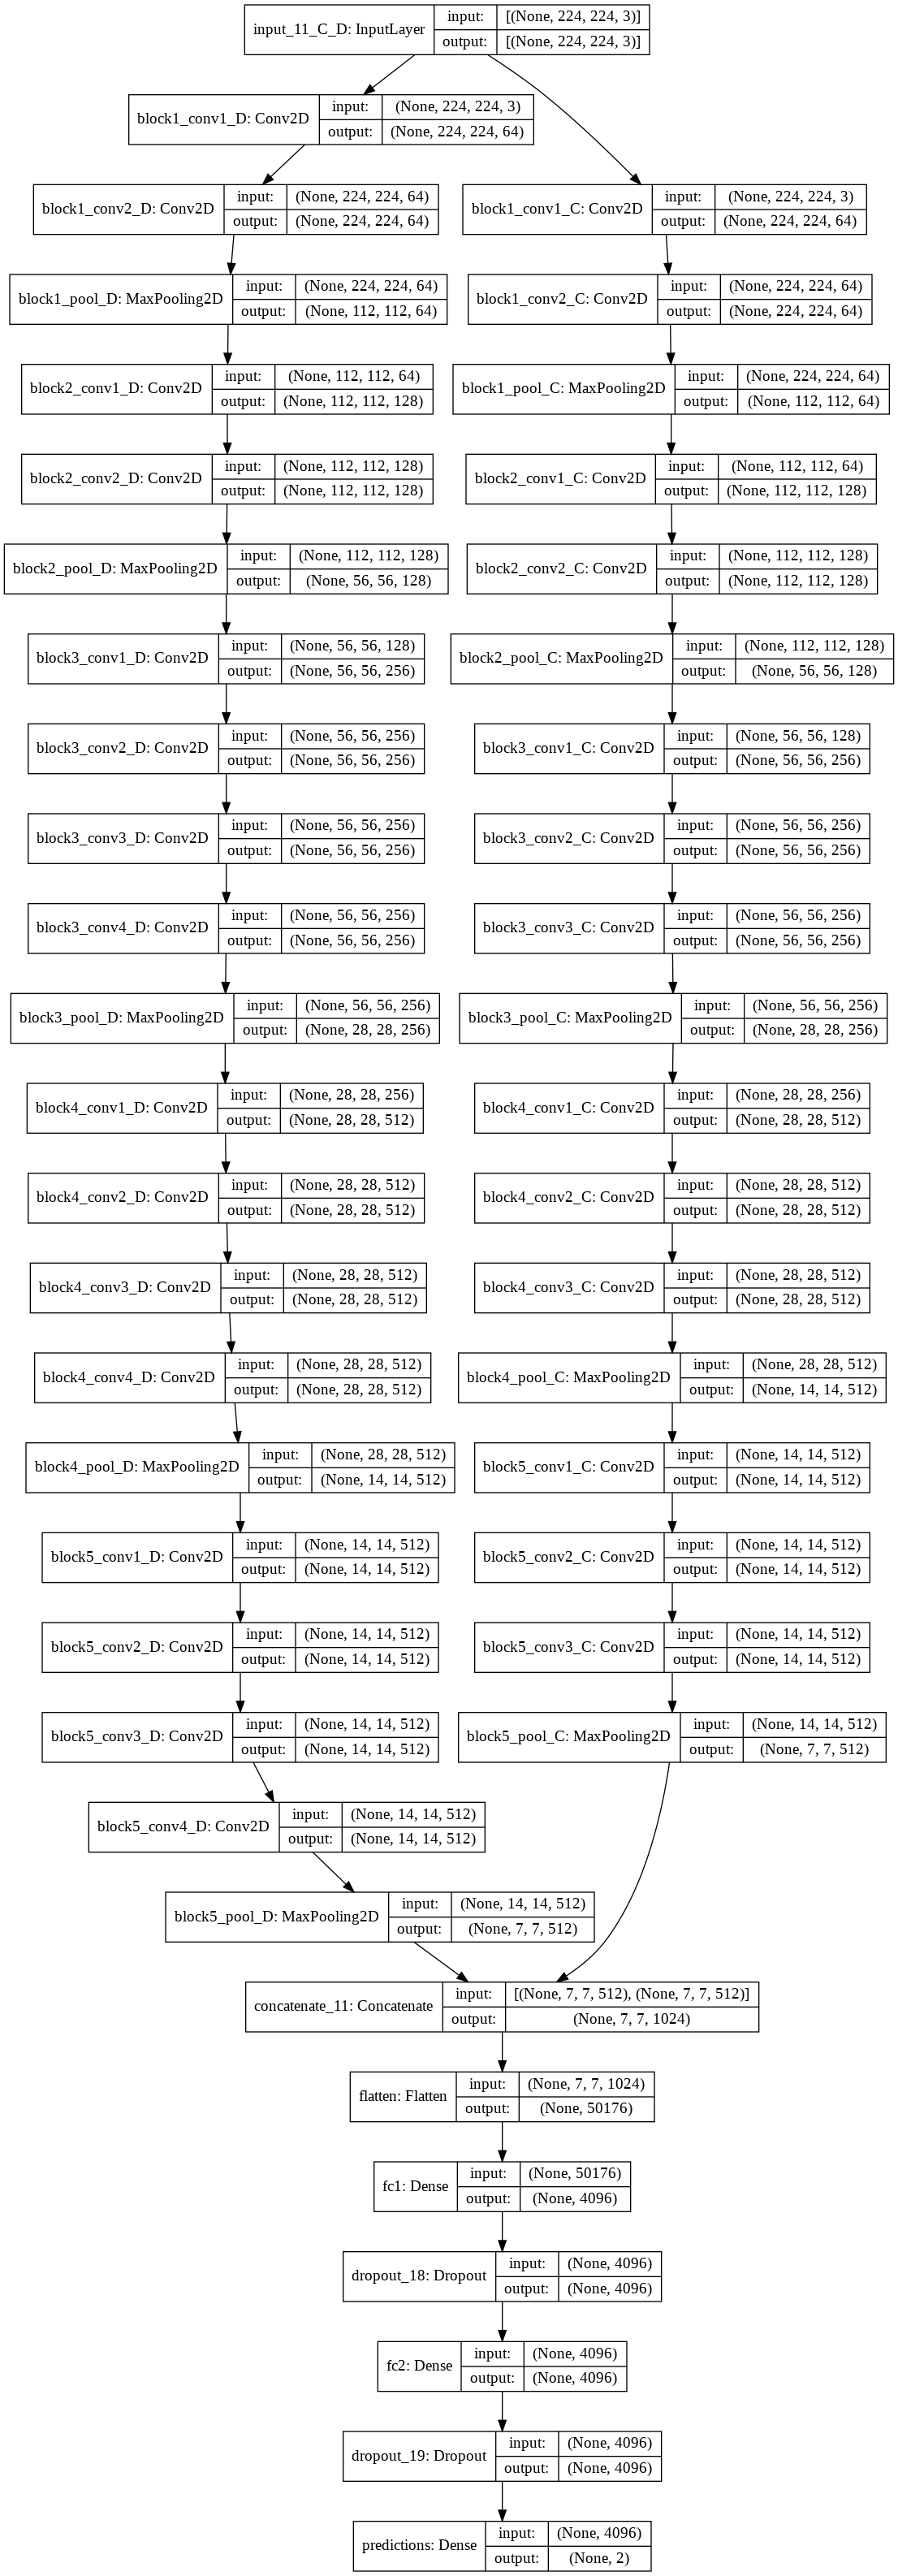

In [203]:
from tensorflow.keras.utils import plot_model
plot_model(Concatenated_model, show_shapes=True)

In [204]:
Concatenated_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11_C_D (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_D (Conv2D)         (None, 224, 224, 64) 1792        input_11_C_D[0][0]               
__________________________________________________________________________________________________
block1_conv2_D (Conv2D)         (None, 224, 224, 64) 36928       block1_conv1_D[0][0]             
__________________________________________________________________________________________________
block1_pool_D (MaxPooling2D)    (None, 112, 112, 64) 0           block1_conv2_D[0][0]             
____________________________________________________________________________________________

In [205]:
from tensorflow.keras import optimizers
sgd = optimizers.SGD()
Concatenated_model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [206]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/ChestVGG_SGD.h5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

Concatenated_model_history=Concatenated_model.fit(
    train_set,
  validation_data=test_set,
  epochs=20,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

Epoch 1/20
147/147 [==============================] - 295s 2s/step - loss: 0.4477 - accuracy: 0.8015 - val_loss: 0.2409 - val_accuracy: 0.9188

Epoch 00001: val_accuracy improved from -inf to 0.91880, saving model to /content/drive/MyDrive/ChestVGG_SGD.h5
Epoch 2/20
147/147 [==============================] - 290s 2s/step - loss: 0.2189 - accuracy: 0.9108 - val_loss: 0.1443 - val_accuracy: 0.9393

Epoch 00002: val_accuracy improved from 0.91880 to 0.93932, saving model to /content/drive/MyDrive/ChestVGG_SGD.h5
Epoch 3/20
147/147 [==============================] - 290s 2s/step - loss: 0.2167 - accuracy: 0.9159 - val_loss: 0.1265 - val_accuracy: 0.9487

Epoch 00003: val_accuracy improved from 0.93932 to 0.94872, saving model to /content/drive/MyDrive/ChestVGG_SGD.h5
Epoch 4/20
147/147 [==============================] - 290s 2s/step - loss: 0.1580 - accuracy: 0.9381 - val_loss: 0.3235 - val_accuracy: 0.8581

Epoch 00004: val_accuracy did not improve from 0.94872
Epoch 5/20
147/147 [=======

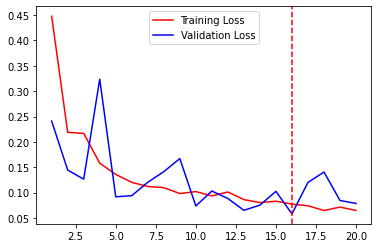

In [207]:
validation_loss=Concatenated_model_history.history['val_loss']
training_loss=Concatenated_model_history.history['loss']
epoch_count=range(1, len(validation_loss)+1)
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, validation_loss, 'b-')
minposs = validation_loss.index(min(validation_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Minimum Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [208]:
from keras.models import load_model
network = load_model('/content/drive/MyDrive/ChestVGG_SGD.h5')

In [209]:
test_set_evaluation = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode = 'categorical')
network.evaluate(test_set_evaluation, steps=1170)

Found 1170 images belonging to 2 classes.
1170/1170 [==============================] - 105s 88ms/step - loss: 0.0579 - accuracy: 0.9795


[0.05792677775025368, 0.9794871807098389]

In [210]:
test_set_evaluation = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode = 'categorical')
preds=[]
predictions=network.predict(test_set_evaluation, steps=1170, verbose=1)
for i in range(len(predictions)):
    if predictions[i][0]>predictions[i][1]:
      preds.append(0)
    else:
      preds.append(1)

Found 1170 images belonging to 2 classes.
1170/1170 [==============================] - 97s 82ms/step


In [211]:
# Method 1 for Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set_evaluation.classes
cf_matrix=confusion_matrix(y_test, preds)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)

[[302  14]
 [ 10 844]]


0.9794871794871794

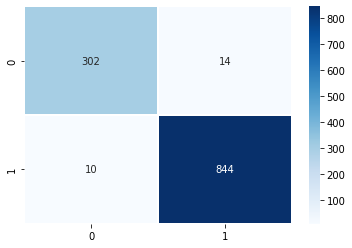

<Figure size 720x504 with 0 Axes>

In [212]:
import seaborn as sns
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd')
plt.figure(figsize=(10,7))
plt.show()

In [213]:
# Method 2 for Confusion Matrix
i=0
A=0
B=0
C=0
D=0
for image, label in test_set_evaluation:
  prediction=network.predict(image)
  if label[0][0]==1 and prediction[0][0]>= prediction[0][1]:
    A+=1
  if label[0][0]==1 and prediction[0][0]<= prediction[0][1]:
    B+=1
  if label[0][1]==1 and prediction[0][0]>= prediction[0][1]:
    C+=1
  if label[0][1]==1 and prediction[0][0]<= prediction[0][1]:
    D+=1
  i+=1
  if i==1170:
    break



In [214]:
print('Actual: Normal: Predicted Normal: ', A)
print('Actual: Normal: Predicted Penumonia: ', B)
print('Actual: Pneumonia: Predicted Normal: ', C)
print('Actual: Pnumonia: Predicted Pneumonia: ', D)

Actual: Normal: Predicted Normal:  302
Actual: Normal: Predicted Penumonia:  14
Actual: Pneumonia: Predicted Normal:  10
Actual: Pnumonia: Predicted Pneumonia:  844


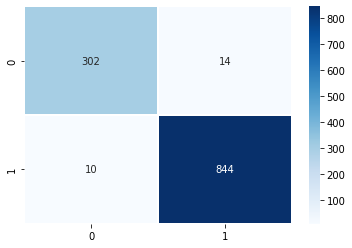

<Figure size 720x504 with 0 Axes>

In [215]:
matrix=[[302,14],
        [10, 844]]
import seaborn as sns
sns.heatmap(matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd')
plt.figure(figsize=(10,7))
plt.show()